In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import torch
import torch.utils.data as data 

from omegaconf import OmegaConf
from torch.nn.parallel import DistributedDataParallel as DDP

# Custom imports
from contrastive_learning.datasets.state_dataset import StateDataset
from contrastive_learning.tests.test_model import load_sbfd, save_all_embeddings, get_closest_embeddings
from contrastive_learning.tests.test_data import plot_state
from contrastive_learning.datasets.dataloaders import get_dataloaders

### Model Loading
Load the trans and the position encoder that will be used in testing the positions

In [2]:
# Start the multiprocessing to load the saved models properly
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29504"

torch.distributed.init_process_group(backend='gloo', rank=0, world_size=1)
torch.cuda.set_device(0)

In [3]:
# Set the device and out_dir
device = torch.device('cuda:0')
out_dir = '/home/irmak/Workspace/DAWGE/contrastive_learning/out/2022.07.17/18-28_sbfd'
cfg = OmegaConf.load(os.path.join(out_dir, '.hydra/config.yaml'))
pos_encoder_path = os.path.join(out_dir, 'models/pos_encoder.pt')
trans_path = os.path.join(out_dir, 'models/trans.pt')
fps = 15

# Load the position encoder and forward linear model
pos_encoder, trans = load_sbfd(cfg, device, pos_encoder_path, trans_path)

In [4]:
print('pos_encoder: {}, trans: {}'.format(pos_encoder, trans))

pos_encoder: DistributedDataParallel(
  (module): PosToEmbedding(
    (model): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=16, bias=True)
    )
  )
), trans: DistributedDataParallel(
  (module): Transition(
    (model): Sequential(
      (0): Linear(in_features=18, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=16, bias=True)
    )
  )
)


### Dump all the embeddings 
Dump all the embeddings index by index to the `out_dir`. 
These embeddings will be used to get the closest kth positions

In [5]:
# Create a whole dataset and dump all the embeddings to the out_dir
data_dir = '/home/irmak/Workspace/DAWGE/src/dawge_planner/data'
dataset = StateDataset(data_dir)
data_loader = data.DataLoader(dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=4)

# Use same method that is used on resnet18 cpn testing
# We are basically doing the same thing - all and all next embeddings in the dataset is saved in out_dir with this
save_all_embeddings(device, len(dataset), cfg.z_dim, pos_encoder, data_loader, out_dir) 

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.55it/s]


### Predict next embeddings for the test dataset
1. Load the `test_loader` using `get_dataloaders` 
2. Predict the next embeddings using `trans` and `pos_encoder`.
3. Find the closest embeddings to the predicted next embeddings. (And their index).
4. Get the indexed item from the whole dataset.

In [6]:
cfg.batch_size = 16
_, test_loader, _ = get_dataloaders(cfg)

In [7]:
print(len(test_loader.dataset))
batch = next(iter(test_loader))
curr_pos, next_pos, action = [b.to(device) for b in batch]
z, z_next = pos_encoder(curr_pos), pos_encoder(next_pos)
z_next_predict = trans(z, action)
print('z.shape: {}, z_next.shape: {}, z_next_predict.shape: {}'.format(
    z.shape, z_next.shape, z_next_predict.shape
))

563
z.shape: torch.Size([16, 16]), z_next.shape: torch.Size([16, 16]), z_next_predict.shape: torch.Size([16, 16])


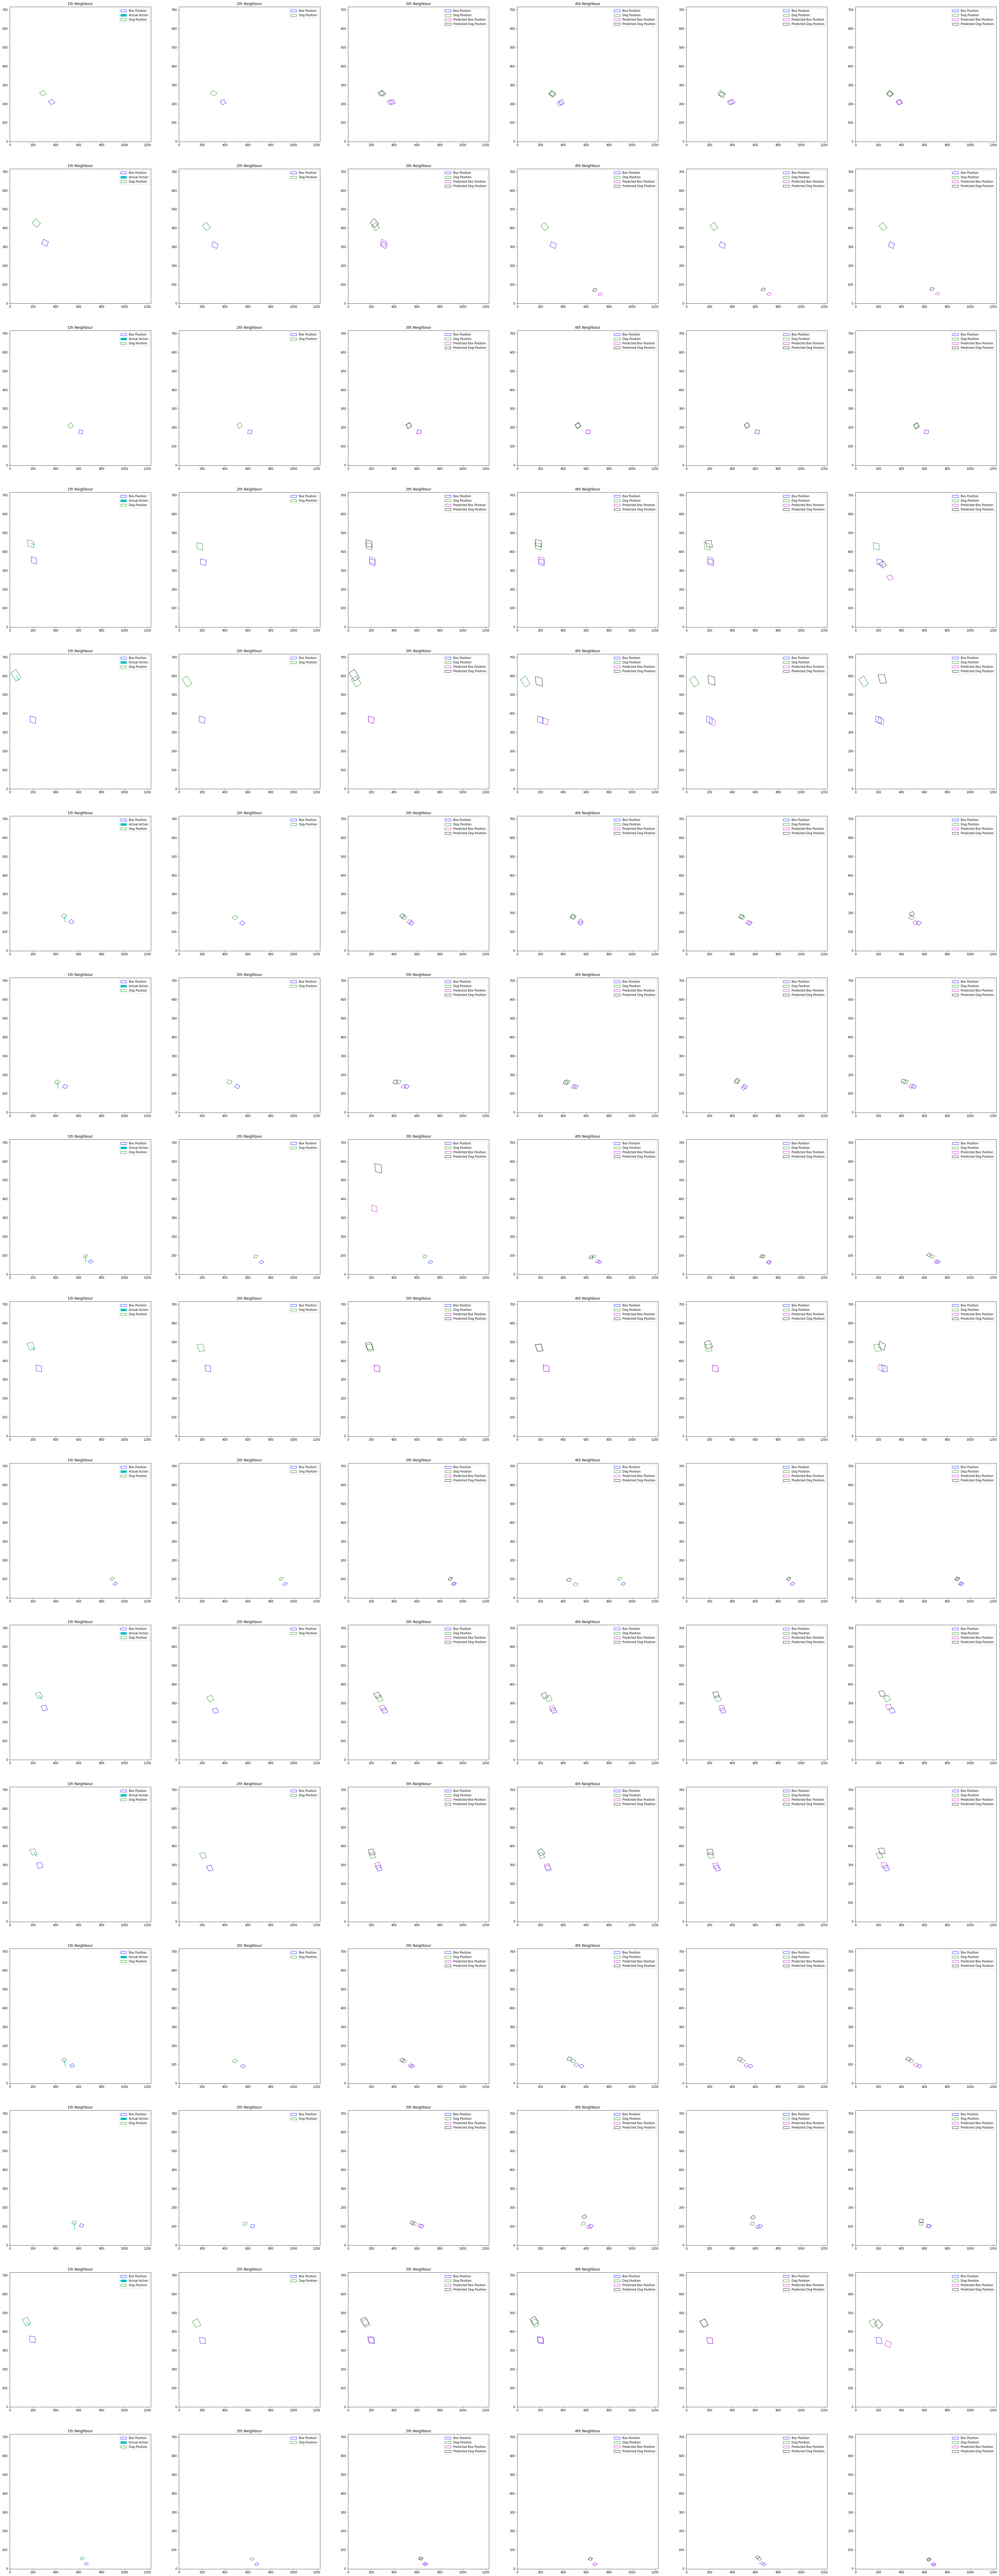

In [9]:
# Plot the current and next positions 
k = 4 # k stands for the kth nearest neighbour
nrows = cfg.batch_size
ncols = k+2 # kth nearest neighbours and current and next position
fig, axs = plt.subplots(figsize=(ncols*10,nrows*10), nrows=nrows, ncols=ncols)

for i in range(cfg.batch_size):
    
    action_np = dataset.denormalize_action(action[i].cpu().detach().numpy())
    curr_pos_np = dataset.denormalize_corner(curr_pos[i].cpu().detach().numpy())
    next_pos_np = dataset.denormalize_corner(next_pos[i].cpu().detach().numpy())
    
    # Plot the current position
    axs[i,0].set_title("Actual Current Positions")
    plot_state(axs[i,0], curr_pos_np, True, action_np, fps, color_scheme=1)
#     plot_state(axs[i,0], next_pos_np, plot_action=False, color_scheme=2)
    
    # Plot the next state
    axs[i,1].set_title("Next Positions")
    plot_state(axs[i,1], next_pos_np, plot_action=False, color_scheme=1)
    
    # TODO: plot the k nearest neighbours - all of them should be plotted on top of the next positions
    curr_obs = curr_pos[i:i+1] if i < cfg.batch_size-1 else curr_pos[i:]
    closest_idx = get_closest_embeddings(
        out_dir = out_dir, 
        encoder = pos_encoder,
        obs = curr_obs,
        k = k)
    for j in range(k):
        kth_pos, _, _ = dataset.getitem(closest_idx[j])
        kth_pos_np = dataset.denormalize_corner(kth_pos.cpu().detach().numpy())
        axs[i,j].set_title("{}th Neighbour".format(j+1))
        plot_state(axs[i,j+2], next_pos_np, plot_action=False, color_scheme=1)
        plot_state(axs[i,j+2], kth_pos_np, plot_action=False, color_scheme=2)
        
plt.savefig(os.path.join(out_dir, 'sbfd_test.jpg'))